In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from IPython.display import Image

In [51]:
!pip install fasttext spacy-transformers spacy

In [52]:
#%reload_ext autoreload
#%autoreload 2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics
import nmslib
import spacy
import fasttext
import fasttext.util
dataset = fetch_20newsgroups(subset='all', shuffle=True, download_if_missing=True)
# http://qwone.com/~jason/20Newsgroups/

np.random.seed(123)
texts = dataset.data # Extract text
target = dataset.target # Extract target
display(len(texts))

18846

In [54]:
texts[4]

'From: Alexander Samuel McDiarmid <am2o+@andrew.cmu.edu>\nSubject: driver ??\nOrganization: Sophomore, Mechanical Engineering, Carnegie Mellon, Pittsburgh, PA\nLines: 15\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n \n1)    I have an old Jasmine drive which I cannot use with my new system.\n My understanding is that I have to upsate the driver with a more modern\none in order to gain compatability with system 7.0.1.  does anyone know\nof an inexpensive program to do this?  ( I have seen formatters for <$20\nbuit have no idea if they will work)\n \n2)     I have another ancient device, this one a tape drive for which\nthe back utility freezes the system if I try to use it.  THe drive is a\njasmine direct tape (bought used for $150 w/ 6 tapes, techmar\nmechanism).  Essentially I have the same question as above, anyone know\nof an inexpensive beckup utility I can use with system 7.0.1\n \nall help and advice appriciated.\n\n'

### Glove


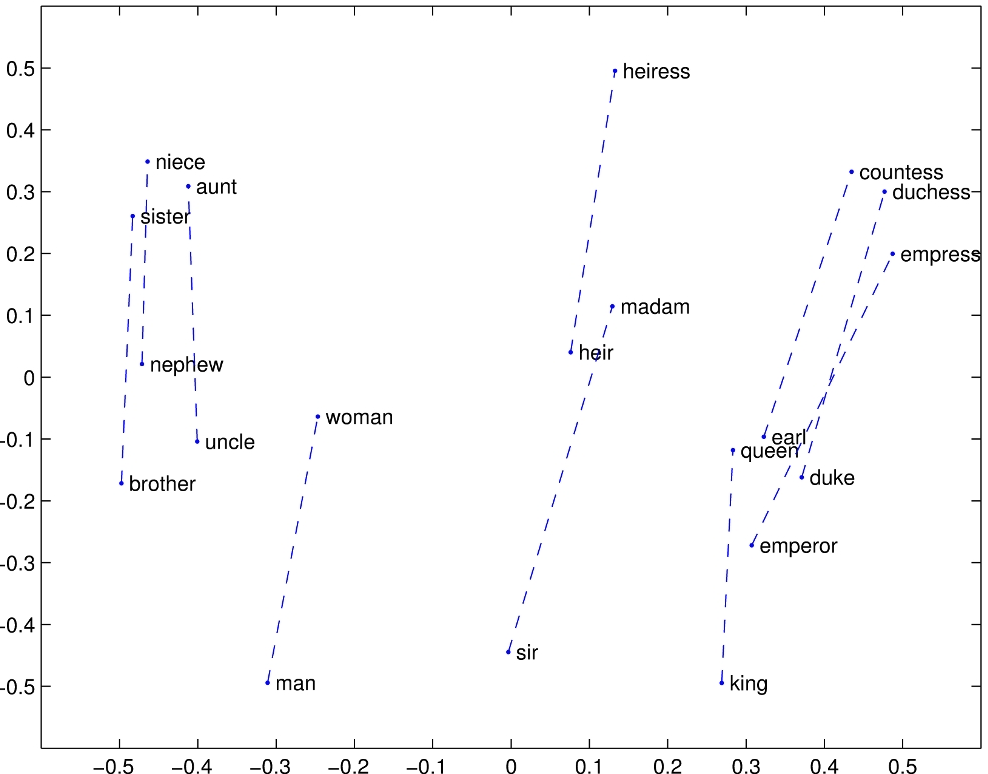

In [55]:
Image('../images/glove.png', width=840, height=640)



### Word2Vec
[Word2Vec paper](https://arxiv.org/pdf/1301.3781v3.pdf)

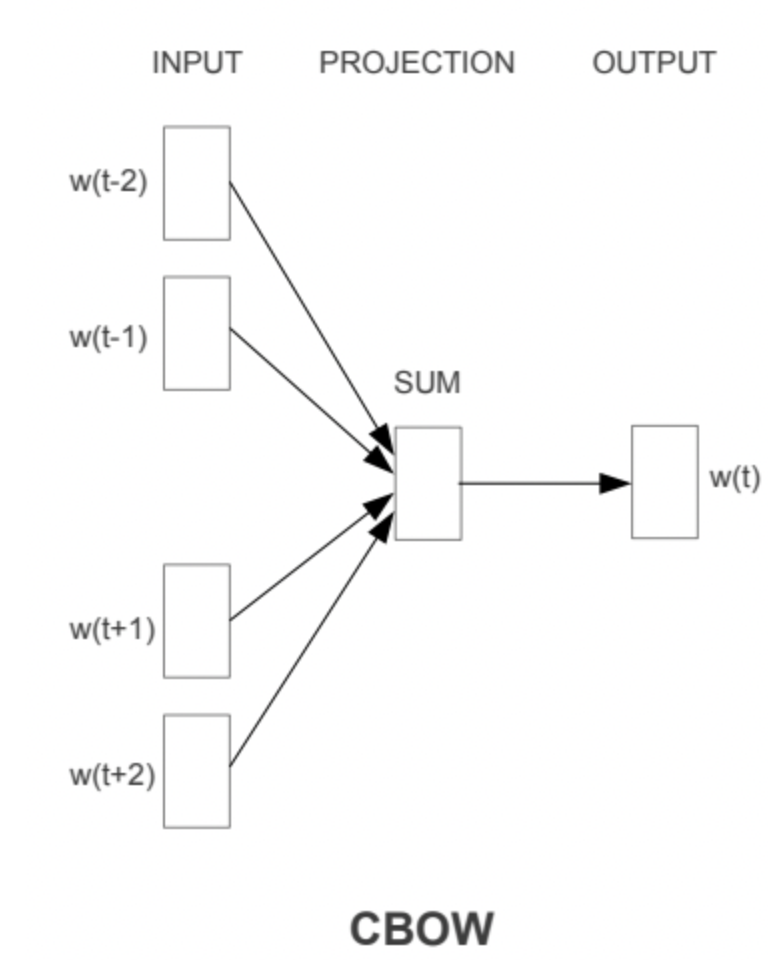

In [56]:
Image('../images/CBOW.png', width=320, height=320)

In [ ]:
Image('../images/SkipGram.png', width=420, height=420)

## FastText
[FastText paper](https://arxiv.org/pdf/1607.04606.pdf). 
But are more approchable explanation can be found [here](https://amitness.com/2020/06/fasttext-embeddings/):

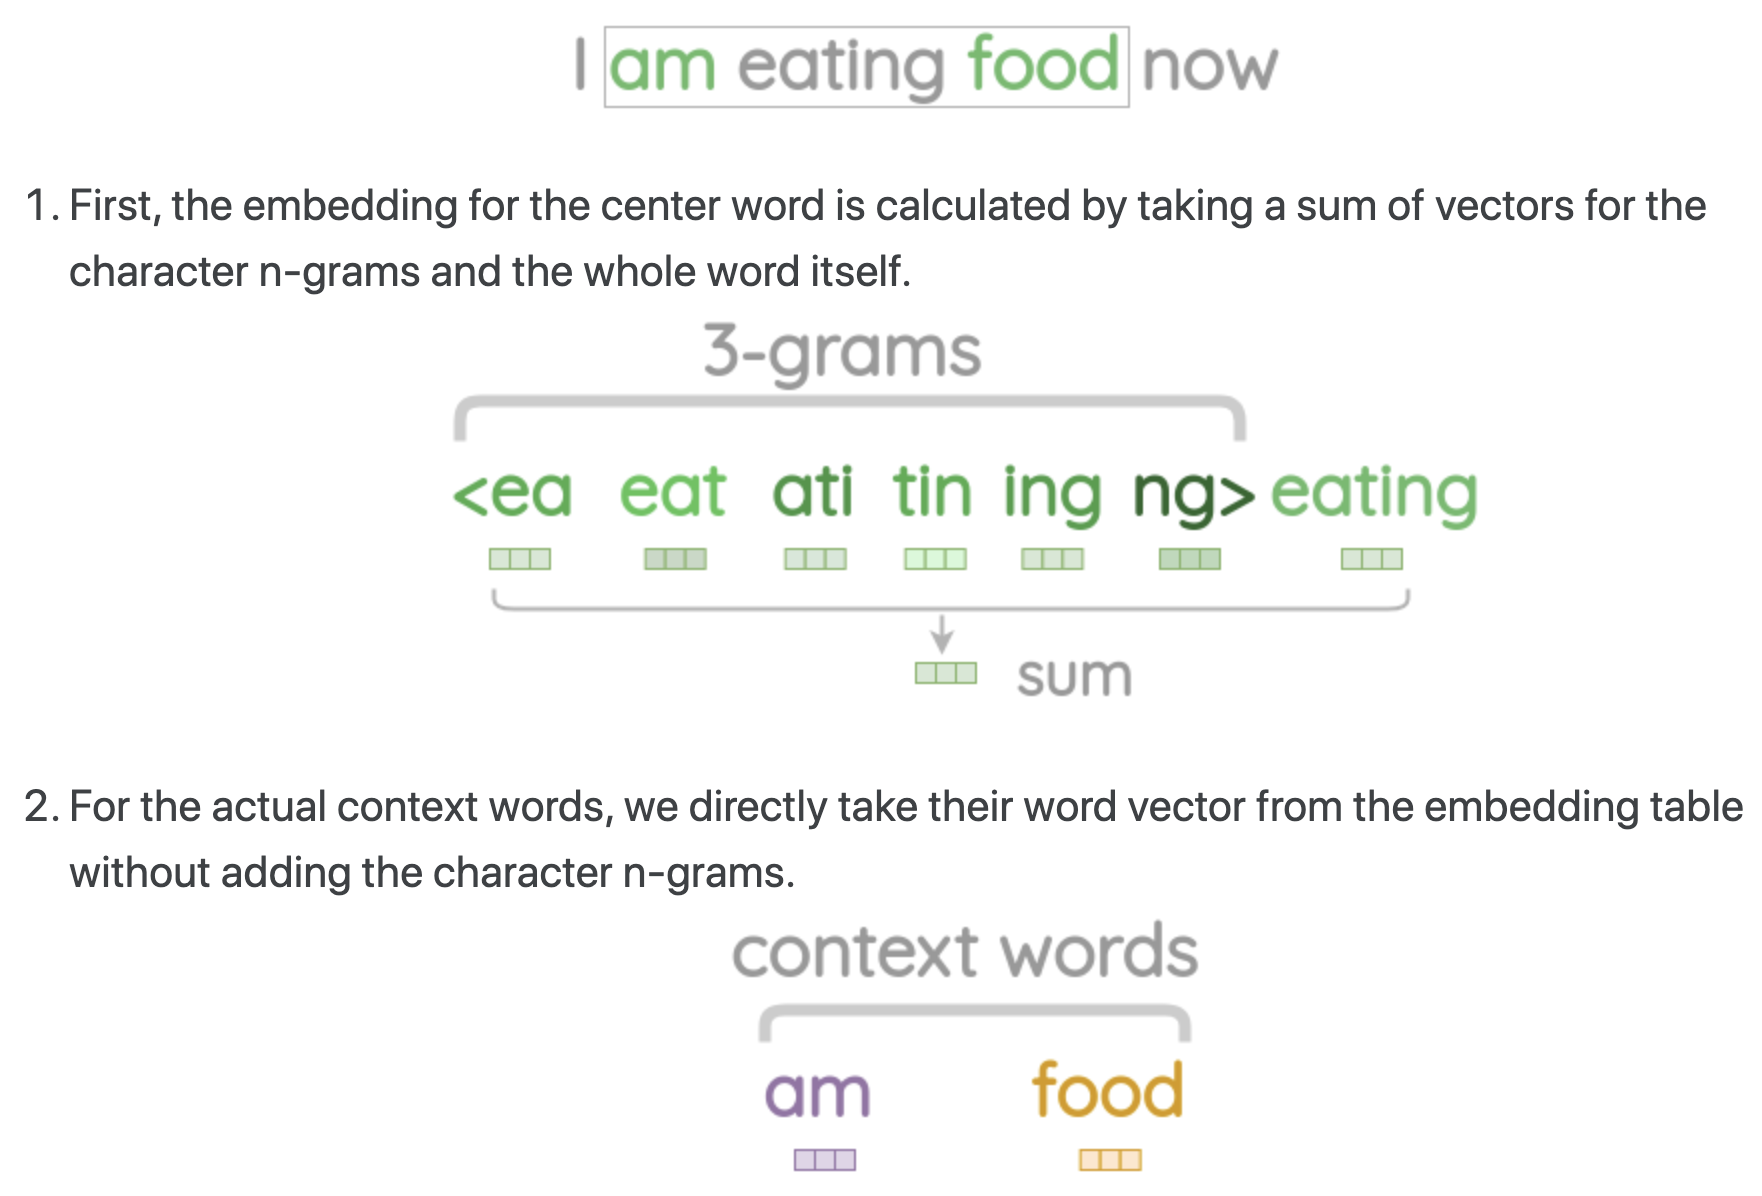

In [57]:
Image('../images/FastText1.png')

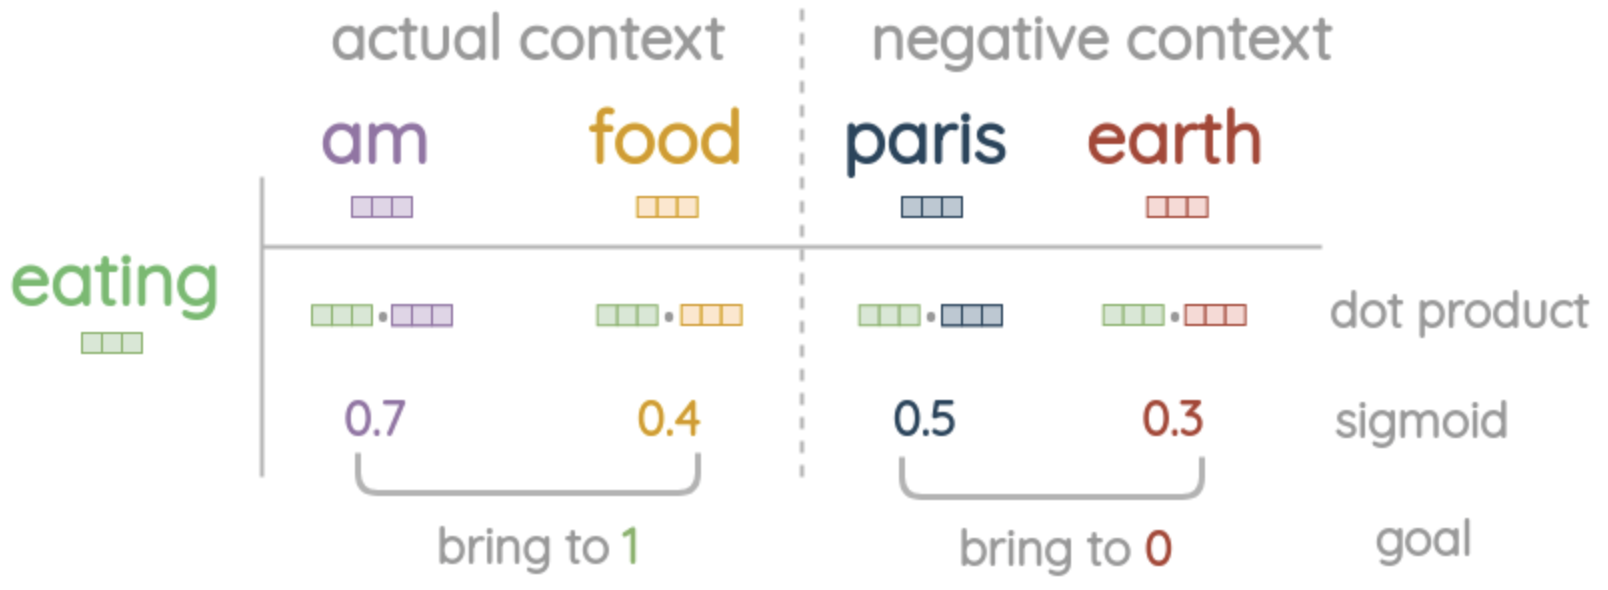

In [58]:
Image('../images/FastText2.png')

In [ ]:
# I skip this step because it takes too long
# fasttext.util.download_model('en', if_exists='ignore')  # English


In [ ]:
# consumes too much RAM for me
# ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
# this is how you can decrease the embedding size
# fasttext.util.reduce_model(ft, 100)
# ft.get_dimension()
# ft.save_model('cc.en.100.bin')

In [59]:
ft = fasttext.load_model('cc.en.100.bin')

In [61]:
ft.get_word_vector('I am')

array([-0.12597063, -0.04258364,  0.2470898 ,  0.11213311,  0.16607006,
       -0.04788677, -0.05561709,  0.08783345, -0.08698461,  0.06810985,
        0.08137836,  0.09119582,  0.16769616, -0.00484111, -0.00352606,
       -0.03444938,  0.06701034,  0.02643219, -0.15301217, -0.08622941,
       -0.04174481, -0.06759413,  0.06181943,  0.00666445,  0.07646812,
        0.02423833,  0.07127596,  0.03751894,  0.07966693,  0.03014506,
        0.10659957, -0.05918339,  0.07505792,  0.02967619, -0.0045435 ,
       -0.04035343, -0.12296458,  0.00539791, -0.09783006,  0.06364233,
        0.10117714, -0.02311754,  0.14362681,  0.07041854, -0.03816186,
        0.04909465,  0.06295404,  0.11303979, -0.02668452,  0.12065387,
       -0.04786908,  0.06549782, -0.05731767,  0.02528081, -0.00829226,
       -0.00810248, -0.01988463,  0.03980628,  0.04132429,  0.08564125,
        0.02316675, -0.07349443, -0.05647055, -0.03119002,  0.05199805,
        0.06200975,  0.00711539,  0.01121991,  0.1513686 ,  0.03

In [62]:
texts = dataset.data # Extract text
target = dataset.target # Extract target

In [63]:
X = np.array([ft.get_word_vector(t) for t in texts])

In [64]:
X.shape

(18846, 100)

In [65]:
import numpy as np
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
# Always scale the input. The most convenient way is to use a pipeline.

clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3),
         X, target, scoring = 'f1_micro', cv=3
)

In [66]:
np.mean(clf)

0.06441685238246843

In [67]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.0781598217128303

In [68]:
ft=None
del ft

### BERT embeddings

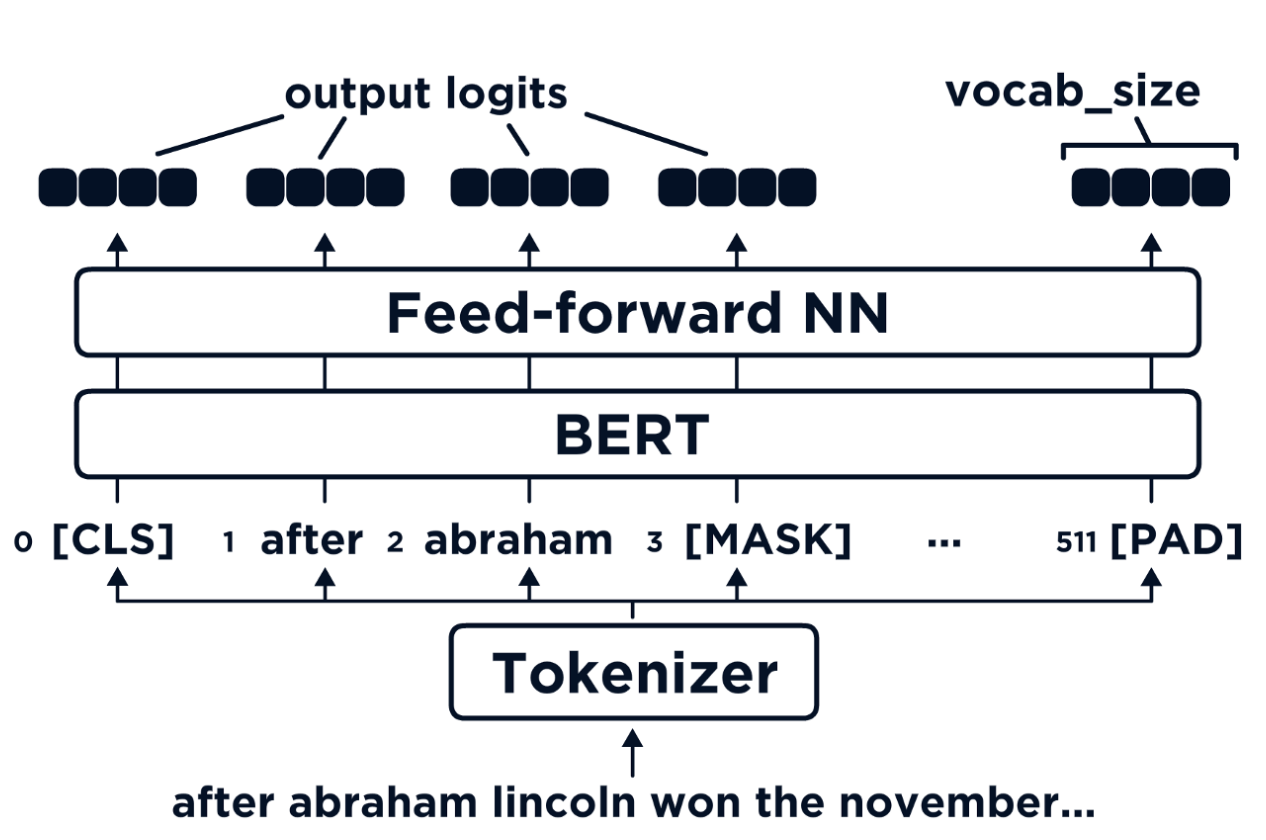

In [69]:
Image('../images/BERT1.png')

In [70]:
!python -m spacy download en_core_web_trf

2022-05-14 10:53:03.727247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 10:53:03.727399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |███                             | 43.3 MB 5.8 MB/s eta 0:01:13^C   |██▊                             | 39.7 MB 5.8 MB/s eta 0:01:13

ERROR: Operation cancelled by user


In [ ]:
nlp = spacy.load(f'en_core_web_trf', disable=["tagger", "ner", "parser", "textcat"])

In [ ]:
X = [doc._.trf_data.tensors[-1] for doc in nlp.pipe(texts)]

In [ ]:
import pickle
with open('spacy_embeddings.pkl', 'wb') as sink:
    pickle.dump(X, sink)

In [72]:
import pickle
with open('spacy_embeddings.pkl', 'rb') as tap:
    X = pickle.load(tap)

In [76]:
X[5].shape

(3, 768)

In [77]:
X0 = np.array([i[0] for i in X])
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X0, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.27931656584951714

In [78]:
X1 = np.array([np.mean(i, axis=0) for i in X])
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X1, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.26530828823092434

### universal sentence encoder
https://pypi.org/project/spacy-universal-sentence-encoder/

In [ ]:
!pip install spacy-universal-sentence-encoder

In [79]:
import spacy_universal_sentence_encoder
nlp = spacy_universal_sentence_encoder.load_model('en_use_md')

In [80]:
doc1 = nlp('Hi there, how are you?')
doc2 = nlp('Hello there, how are you doing today?')

In [81]:
import numpy as np
np.dot(doc1.vector, doc2.vector)

0.8228497

In [82]:
doc1.similarity(doc2)

0.8228496310812492

In [ ]:
X_md = [nlp(t).vector for t in texts]
import pickle
with open('universal_sentence_encoder_embeddings.pkl', 'wb') as sink:
    pickle.dump(X_md, sink)

In [83]:
with open('universal_sentence_encoder_embeddings.pkl', 'rb') as tap:
    X_md = pickle.load(tap)

In [85]:
X_md[0].shape

(512,)

In [86]:
import numpy as np
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
# Always scale the input. The most convenient way is to use a pipeline.
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X_md, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.7214793590151757

In [87]:
# norm='l2' is default
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.3)
X1 = vectorizer.fit_transform(texts)

print(f'{X1.shape[0]}, {X1.shape[1]}')


18846, 173438


In [88]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X1, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.8991297888146025

### Sentence-Transformers
The initial [paper](https://arxiv.org/pdf/1908.10084.pdf)

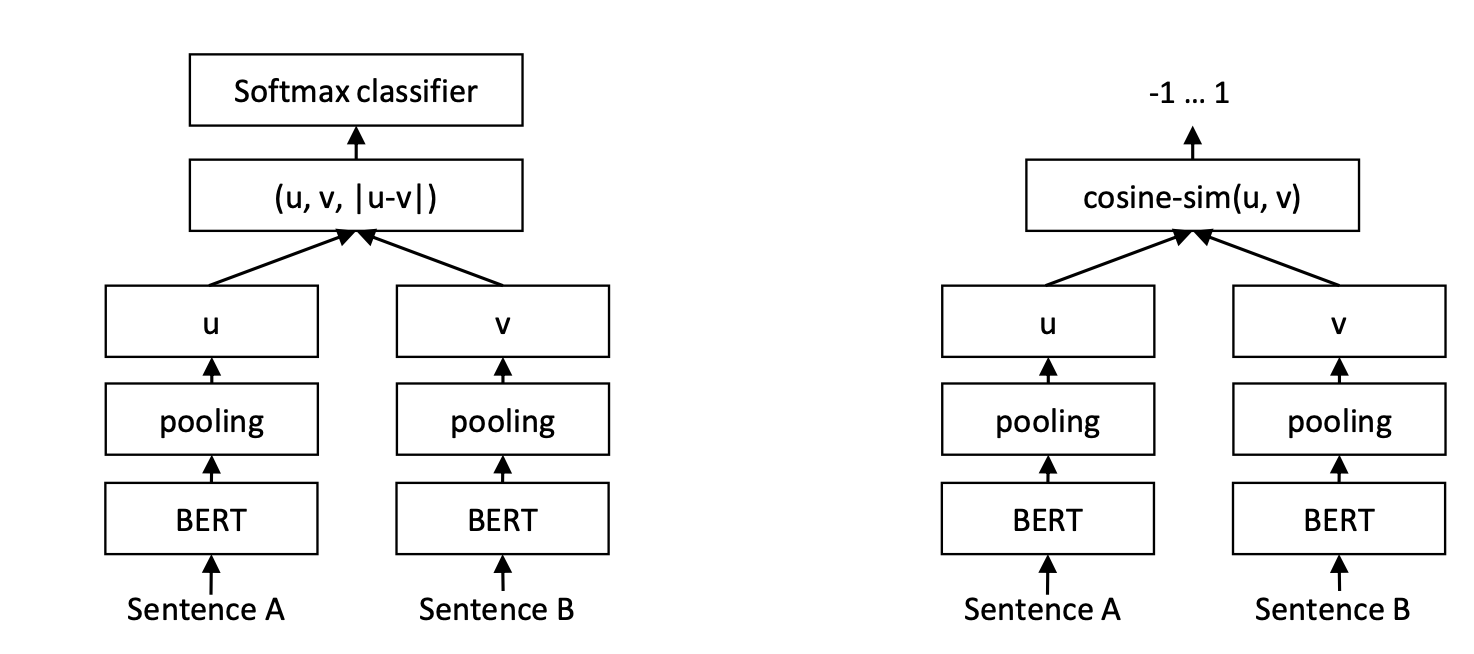

In [89]:
Image('../images/sentence-transformers1.png')

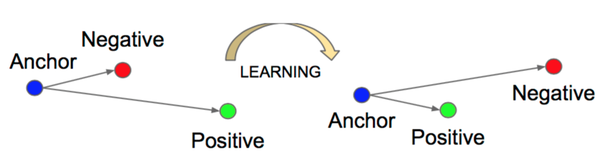

In [90]:
Image('../images/triplet_loss.png')

In [1]:
!pip install nltk sentence_transformers

In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import defaultdict
import json
import os
import pickle
from itertools import chain
from nltk.tokenize import sent_tokenize
import torch
import nltk
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### multilingual sentence transformer
This is the [publication](https://arxiv.org/abs/2004.09813) on this ingenious idea.

For the News-DataSet we could also use BertTopic:
https://towardsdatascience.com/topic-modeling-with-lsa-plsa-lda-nmf-bertopic-top2vec-a-comparison-5e6ce4b1e4a5

In [7]:
Image('../images/multi_sbert.png')

NameError: name 'Image' is not defined

In [8]:
source = '/home/martin/python/fhnw_lecture/data'
try:
    model = SentenceTransformer(\
                    os.path.join(source, 'multi-qa-mpnet-base-dot-v1.pth'), device='cpu')
except:
    model = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device='cpu')
    model.save(os.path.join(source, 'multi-qa-mpnet-base-dot-v1.pth'))

model = model.to('cpu')
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
with torch.no_grad():
    embeddings = model.encode(texts, device='cpu')

In [ ]:
import pickle
with open('sentence_transformer_embeddings.pkl', 'wb') as sink:
    pickle.dump(embeddings, sink)

In [92]:
import pickle
with open('sentence_transformer_embeddings.pkl', 'rb') as tap:
    embeddings = pickle.load(tap)

In [93]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         embeddings, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

0.8507906186989281

can we combine two different approaches? TF-IDF and the sentence embeddings?

In [ ]:
from scipy import sparse
bigX = sparse.hstack([embeddings,X1])   

In [ ]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         bigX, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

### small demonstration

In [3]:
!pip install bs4

In [20]:
import requests
response_de=requests.get('https://www.eda.admin.ch/aboutswitzerland/de/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_it = requests.get('https://www.eda.admin.ch/aboutswitzerland/it/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_fr = requests.get('https://www.eda.admin.ch/aboutswitzerland/fr/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_en = requests.get('https://www.eda.admin.ch/aboutswitzerland/en/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_es = requests.get('https://www.eda.admin.ch/aboutswitzerland/es/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')

In [21]:
from bs4 import BeautifulSoup
soup_de = BeautifulSoup(response_de.text, features="html.parser")
soup_it = BeautifulSoup(response_it.text, features="html.parser")
soup_fr = BeautifulSoup(response_fr.text, features="html.parser")
soup_en = BeautifulSoup(response_en.text, features="html.parser")
soup_es = BeautifulSoup(response_es.text, features="html.parser")

In [22]:
soup_de


<!DOCTYPE html>

<html lang="de">
<head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<title>Die Sprachen – Fakten und Zahlen</title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<meta content="on" http-equiv="cleartype"/>
<meta content="Nebst den Landessprachen Deutsch, Französisch, Italienisch und Rätoromanisch sind Englisch und Portugiesisch in der Schweiz verbreitet." name="description"/>
<meta content="Sprachen Schweiz,Mehrsprachigkeit Schweiz,Schweizer Dialekt,Schweizerdeutsch" name="keywords"/>
<meta content="telephone=no" name="format-detection">
<meta content="Die Sprachen – Fakten und Zahlen" property="og:title"/>
<meta content="Nebst den Landessprachen Deutsch, Französisch, Italienisch und Rätoromanisch sind Englisch und Portugiesisch in der Schweiz verbreitet." property="og:description"/>
<meta content="https://www.eda.admin.ch/etc.clientlibs/eda/base/clientlibs/publis

In [23]:
import re
paragraphs_de = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_de.find_all("p")]
paragraphs_it = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_it.find_all("p")]
paragraphs_fr = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_fr.find_all("p")]
paragraphs_en = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_en.find_all("p")]
paragraphs_es = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_es.find_all("p")]

In [24]:
paragraphs_de

['Die Schweiz entdecken',
 'Schweizerische Bundeskanzlei BK',
 'Eidgenössisches Departement für auswärtige Angelegenheiten EDA',
 'Eidgenössisches Departement des Innern EDI',
 'Eidgenössisches Justiz- und Polizeidepartement EJPD',
 'Eidgenössisches Departement für Verteidigung, Bevölkerungsschutz und Sport VBS',
 'Eidgenössisches Finanzdepartement EFD',
 'Eidgenössisches Departement für Wirtschaft, Bildung und Forschung WBF',
 'Eidgenössisches Departement für Umwelt, Verkehr, Energie und Kommunikation UVEK',
 'Internationale Polizeieinsätze der Schweiz',
 'Afghanistan',
 'Ägypten',
 'Albanien',
 'Algerien',
 'Andorra',
 'Angola',
 'Antigua und Barbuda',
 'Äquatorialguinea',
 'Argentinien',
 'Armenien',
 'Aserbaidschan',
 'Äthiopien',
 'Australien',
 'Bahamas',
 'Bahrain',
 'Bangladesch',
 'Barbados',
 'Belarus',
 'Belgien',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivien',
 'Bosnien und Herzegowina',
 'Botsuana',
 'Brasilien',
 'Brunei Darussalam',
 'Bulgarien',
 'Burkina Faso',
 'Burundi'

In [25]:
source = '/home/martin/python/fhnw_lecture/data'
try:
    model = SentenceTransformer(\
                    os.path.join(source, 'paraphrase-multilingual-mpnet-base-v2.pth'), device='cpu')
except:
    model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2', device='cpu')
    model.save(os.path.join(source, 'paraphrase-multilingual-mpnet-base-v2.pth'))

model = model.to('cpu')
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [26]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

all_paragraphs = paragraphs_de + paragraphs_it + paragraphs_fr + paragraphs_en + paragraphs_es
sentences = [s for p in all_paragraphs for s in sent_tokenize(p if len(p.split(' ')) > 2 else '')]

with torch.no_grad():
    multi_lang_embeddings = model.encode(sentences, device='cpu')

[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
multi_lang_embeddings.shape

(416, 768)

### visualization via u-map

In [28]:
import umap.umap_ as umap
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

reducer = umap.UMAP()

In [29]:
h, w = multi_lang_embeddings.shape
normalized = multi_lang_embeddings/\
      np.resize(np.linalg.norm(multi_lang_embeddings, axis=1), (h, 1))

In [30]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [31]:
umap_transformed = reducer.fit_transform(normalized)

In [32]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import figure, output_file, save

embedding_df = pd.DataFrame(umap_transformed, columns=('x', 'y'))
embedding_df['sentences'] = sentences
# embedding_df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(embedding_df)
color_mapping = CategoricalColorMapper(factors=[str(i) for i in np.arange(0,9)],
                                       palette=Spectral10)
output_file(filename='/home/martin/python/fhnw_lecture/images/multilang_umap.html', title = 'sentence similarity')
plot_figure = figure(
    title='UMAP projection of sentence embeddings',
    plot_width=1000,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>sentence:</span>
        <span style='font-size: 18px'>@sentences</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='sentences',transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
#save(plot_figure)
show(plot_figure)

### Monolingual models can be found on 'the Huggingface':
best [german model](https://huggingface.co/T-Systems-onsite/german-roberta-sentence-transformer-v2)